In [1]:
import numpy as np
from rnn.arch import RNN
from vae.arch import VAE
import matplotlib.pyplot as plt
from gym.utils import seeding
batch_num = 0

/Users/davidfoster/.virtualenvs/worldmodels/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
rnn = RNN()
rnn.set_weights('./rnn/weights.h5')

vae = VAE()
vae.set_weights('./vae/weights.h5')

In [3]:
obs_data = np.load('./data/obs_data_car_racing_' + str(batch_num) + '.npy') 
action_data = np.load('./data/action_data_car_racing_' + str(batch_num) + '.npy')
reward_data = np.load('./data/reward_data_car_racing_' + str(batch_num) + '.npy') 
done_data = np.load('./data/done_data_car_racing_' + str(batch_num) + '.npy')
rnn_input = np.load('./data/rnn_input_' + str(batch_num) + '.npy') 
rnn_output = np.load('./data/rnn_output_' + str(batch_num) + '.npy')

In [4]:
rnn_input[0].shape

(299, 35)

In [5]:
rnn_output[0].shape

(299, 34)

In [6]:
GAUSSIAN_MIXTURES = 5
Z_DIM = 32
z_dim = 32

def get_mixture_coef(y_pred):

    d = GAUSSIAN_MIXTURES * Z_DIM

    rollout_length = y_pred.shape[1]

    pi = y_pred[:,:,:d]
    mu = y_pred[:,:,d:(2*d)]
    log_sigma = y_pred[:,:,(2*d):(3*d)]
    reward = y_pred[:,:,(3*d):(3*d+1)]
    done = y_pred[:,:,(3*d+1):]

    pi = np.reshape(pi, [-1, rollout_length, GAUSSIAN_MIXTURES, Z_DIM])
    mu = np.reshape(mu, [-1, rollout_length, GAUSSIAN_MIXTURES, Z_DIM])
    log_sigma = np.reshape(log_sigma, [-1, rollout_length, GAUSSIAN_MIXTURES, Z_DIM])

    pi = np.exp(pi) / np.sum(np.exp(pi), axis=2, keepdims=True)
    sigma = np.exp(log_sigma)

    return pi, mu, sigma, reward, done

In [7]:
def get_pi_idx(x, pdf):
  # samples from a categorial distribution
  N = pdf.size
  accumulate = 0
  for i in range(0, N):
    accumulate += pdf[i]
    if (accumulate >= x):
      return i
  random_value = np.random.randint(N)
  #print('error with sampling ensemble, returning random', random_value)
  return random_value

In [8]:
def sample_z(mu, sigma):
    z = mu + sigma * np_random.randn(*sigma.shape)
    return z

In [9]:
np_random, seed = seeding.np_random()

In [10]:
def sample_next_mdn_output(obs):
    
    y_pred = rnn.model.predict(np.array([[obs]]))
    _pi, _mu, _sigma, _reward, _done = get_mixture_coef(y_pred)

    pi = _pi[0,0,:,:]
    mu = _mu[0,0,:,:]
    sigma = _sigma[0,0,:,:]
    reward = _reward[0,0,:]
    done = _done[0,0,:]

    chosen_pi = np.zeros(z_dim)
    chosen_mu = np.zeros(z_dim)
    chosen_sigma = np.zeros(z_dim)

    for j in range(z_dim):
      idx = get_pi_idx(np_random.rand(), pi[:,j])
      chosen_pi[j] = idx
      chosen_mu[j] = mu[idx, j]
      chosen_sigma[j] = sigma[idx, j]

    next_z = sample_z(chosen_mu, chosen_sigma)

    reward = np.exp(reward) / (1 + np.exp(reward))
    done = np.exp(done) / (1 + np.exp(done))

    if reward > 0.5:
        next_reward = 3.2
    else:
        next_reward = -0.1

    if done > 0.5:
        next_done = True
    else:
        next_done = False
        
    return next_z, next_reward, next_done, chosen_mu, chosen_sigma, chosen_pi

In [32]:
idx = 51
obs = rnn_input[0][idx]
actual = rnn_output[0][idx] 
print(obs)
print(actual)

[-0.08085405  0.79356366 -0.45640498  0.57098371  0.07596041  0.1884623
  0.13534099 -0.20389371  0.47626004 -0.59010834  0.55656809 -0.10050996
  0.07420243  0.05501225  0.82951158  0.17075323  0.18568632  0.28184897
 -0.25235027  0.01712789  0.52777451  0.05759776 -0.06968933 -0.58070183
  0.21361732 -0.2576319  -2.50369358  0.26601374 -1.59571147  0.01395124
 -0.04116146 -1.19923556  0.          1.          0.        ]
[-0.09969877  0.88823479 -0.53118771  0.57391649  0.14660884  0.25712913
  0.12652907 -0.20380633  0.50952441 -0.60271031  0.52950698 -0.14730118
  0.08701086  0.01233077  0.78943592  0.14903311  0.18729617  0.27868229
 -0.17408542  0.07637896  0.4667123   0.13437158 -0.05626293 -0.53932166
  0.09737018 -0.15297094 -2.48393011  0.23491728 -1.72058487  0.02089619
 -0.07690908 -1.11532295  0.          0.        ]


In [33]:
vae.encoder_mu_log_var.predict(np.array([obs_data[4][idx]]))

[array([[-0.12992339, -1.0771388 , -1.2458864 , -0.08433475, -0.03642885,
         -0.45453078, -0.12428801, -0.1704531 , -0.13326722,  0.05550963,
          0.77233577,  0.21587795, -0.02991135, -0.00271763, -0.7857278 ,
         -0.19608149,  0.0226208 ,  0.22197863, -0.19745263, -0.25374576,
         -0.23654425, -0.076895  ,  0.21258405,  0.4773887 ,  0.10261494,
         -0.13168171, -2.31279   ,  0.0390784 ,  0.5014414 ,  0.10023031,
         -0.07899055, -0.30848524]], dtype=float32),
 array([[-1.1971948 , -2.6422117 , -2.5475183 , -0.01093458, -0.21853165,
         -2.0038633 , -0.5489326 , -0.44209236,  0.056089  , -0.0902566 ,
         -2.3084095 ,  0.09707913, -0.04998481, -0.12577961, -0.7145065 ,
         -0.12660325, -0.10941827, -0.33521357, -0.2832477 , -0.18836965,
         -0.11168782,  0.04451053, -0.01064344, -0.30865484, -0.37667555,
         -1.5648048 , -3.4662585 , -0.13030161, -3.0294948 ,  0.13102065,
         -0.11477968, -1.9139647 ]], dtype=float32)]

<function matplotlib.pyplot.show>

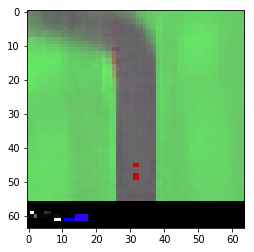

In [34]:
z_decoded = vae.decoder.predict(np.array([obs[:32]]))[0]
plt.imshow(z_decoded)
plt.show

<function matplotlib.pyplot.show>

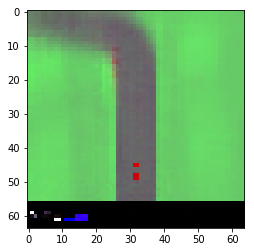

In [35]:
actual_z_decoded = vae.decoder.predict(np.array([actual[:32]]))[0]
plt.imshow(actual_z_decoded)
plt.show

<function matplotlib.pyplot.show>

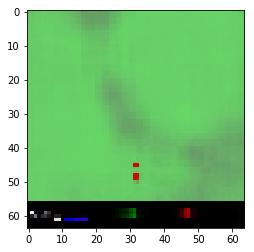

In [48]:
next_z, next_reward, next_done, chosen_mu, chosen_sigma, chosen_pi = sample_next_mdn_output(obs)
# print(chosen_pi)
# print(chosen_mu)
# print(chosen_sigma)
# print(next_z)

next_z_decoded = vae.decoder.predict(np.array([next_z]))[0]
plt.imshow(next_z_decoded)
plt.show

<function matplotlib.pyplot.show>

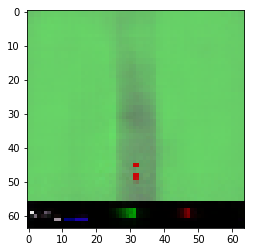

In [37]:
next_z_decoded = vae.decoder.predict(np.array([chosen_mu]))[0]
plt.imshow(next_z_decoded)
plt.show

In [37]:
y_pred = rnn.model.predict(np.array([[obs]]))

In [119]:
d = GAUSSIAN_MIXTURES * Z_DIM

rollout_length = y_pred.shape[1]

pi = y_pred[:,:,:d]
mu = y_pred[:,:,d:(2*d)]
log_sigma = y_pred[:,:,(2*d):(3*d)]
reward = y_pred[:,:,(3*d):(3*d+1)]
done = y_pred[:,:,(3*d+1):]

In [120]:
done

array([[[0.04972614]]], dtype=float32)

In [101]:
pi = np.reshape(pi, [-1, rollout_length, GAUSSIAN_MIXTURES, Z_DIM])
mu = np.reshape(mu, [-1, rollout_length, GAUSSIAN_MIXTURES, Z_DIM])
log_sigma = np.reshape(log_sigma, [-1, rollout_length, GAUSSIAN_MIXTURES, Z_DIM])

pi = np.exp(pi) / np.sum(np.exp(pi), axis=2, keepdims=True)
sigma = np.exp(log_sigma)

In [ ]:
pii

In [99]:
_pi, _mu, _sigma, _reward, _done = get_mixture_coef(y_pred)

pi = _pi[0,0,:,:]
mu = _mu[0,0,:,:]
sigma = _sigma[0,0,:,:]
reward = _reward[0,0,:]
done = _done[0,0,:]

In [100]:
y_pred

array([[[-8.42247158e-02,  1.73397347e-01, -2.22273692e-02,
         -1.93779916e-03, -2.23032553e-02,  2.75323808e-01,
          5.54454252e-02, -6.38567358e-02,  2.76359648e-01,
         -4.65244830e-01, -2.51006335e-03, -1.70731142e-01,
          1.00091226e-01, -1.06834263e-01, -2.87596613e-01,
         -3.88700575e-01, -2.53606379e-01, -3.69105041e-01,
          1.37216941e-01, -3.15674953e-02,  3.39195758e-01,
         -1.69149503e-01, -1.64942399e-01, -3.07070017e-01,
         -6.09543920e-02, -7.27650598e-02,  2.27079540e-01,
          6.96767718e-02,  3.74249890e-02, -1.20351635e-01,
         -2.31335476e-01, -3.05184219e-02, -3.04748058e-01,
         -2.95856465e-02, -1.76349446e-01,  1.87404975e-02,
          1.20319456e-01, -1.45747215e-01, -3.38560790e-02,
          2.04621106e-02, -2.09008187e-01,  3.43991458e-01,
          3.72321814e-01,  2.83092558e-02,  3.49973375e-03,
          1.02967232e-01,  4.53605317e-03,  2.98518836e-01,
         -1.08144417e-01,  4.20536011e-0